# Panikee Model Generator
##### NLP Based Panic Button

### Reference 
- https://colab.research.google.com/github/tensorflow/tfjs-models/blob/master/speech-commands/training/browser-fft/training_custom_audio_model_in_python.ipynb#scrollTo=3BbsTxcuCwYO
- https://blog.tensorflow.org/2020/12/build-sound-classification-models-for-mobile-apps-with-teachable-machine-and-tflite.html

In [120]:
import glob
import json
import os
import random
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import tensorflow as tf
import tensorflowjs as tfjs
from tqdm import tqdm

print(tf.__version__)
print(tfjs.__version__)

2.5.0
1.7.0


In [121]:
# Download the Tensorflow.js Speech Commands and Related Preprocessing Models
!mkdir -p preprocess_model
!curl -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/metadata.json -o preprocess_model/metadata.json 
!curl -o preprocess_model/model.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/model.json
!curl -o preprocess_model/group1-shard1of2 -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard1of2
!curl -o preprocess_model/group1-shard2of2 -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard2of2
!curl -o preprocess_model/sc_preproc_model.tar.gz -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/conversion/sc_preproc_model.tar.gz
!cd preprocess_model/ && tar xzvf sc_preproc_model.tar.gz

sc_preproc_model/
sc_preproc_model/assets/
sc_preproc_model/variables/
sc_preproc_model/variables/variables.data-00000-of-00001
sc_preproc_model/variables/variables.index
sc_preproc_model/saved_model.pb


In [122]:
# Settings
DATASET_PATH       = "../../Dataset/mini_speech_commands"
PREPROC_MODEL_PATH = './preprocess_model/sc_preproc_model/'

In [123]:
# Load the proceesing model
preproc_model = tf.keras.models.load_model(PREPROC_MODEL_PATH)
preproc_model.summary()
preproc_model.input_shape

# Constants
TARGET_SAMPLE_RATE = 44100   # Target sampling rate. 
WAVEFORM_LEN       = preproc_model.input_shape[-1]
WORDS              = ("no", "yes", "marvin", "tolong")

Model: "audio_preproc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_preprocessing_layer (A (None, None, 232, 1)      2048      
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


In [124]:
def resample_wavs(dir_path, target_sample_rate=44100):
  """Resample the .wav files in an input directory to given sampling rate.
  
  The resampled waveforms are written to .wav files in the same directory with
  file names that ends in "_44100hz.wav".

  44100 Hz is the sample rate required by the preprocessing model. It is also
  the most widely supported sample rate among web browsers and mobile devices.
  For example, see:
  https://developer.mozilla.org/en-US/docs/Web/API/AudioContextOptions/sampleRate
  https://developer.android.com/ndk/guides/audio/sampling-audio

  Args:
    dir_path: Path to a directory that contains .wav files.
    target_sapmle_rate: Target sampling rate in Hz.
  """
  wav_paths = glob.glob(os.path.join(dir_path, "*.wav"))
  resampled_suffix = "_%shz.wav" % target_sample_rate
  for i, wav_path in tqdm(enumerate(wav_paths)):
    if wav_path.endswith(resampled_suffix):
      continue
    sample_rate, xs = wavfile.read(wav_path)
    xs = xs.astype(np.float32)
    xs = librosa.resample(xs, sample_rate, TARGET_SAMPLE_RATE).astype(np.int16)
    resampled_path = os.path.splitext(wav_path)[0] + resampled_suffix
    wavfile.write(resampled_path, target_sample_rate, xs)


for word in WORDS:
    word_dir = os.path.join(DATASET_PATH, word)
    assert os.path.isdir(word_dir)
    resample_wavs(word_dir, target_sample_rate=TARGET_SAMPLE_RATE)

2000it [01:15, 26.62it/s]
2000it [01:14, 26.95it/s]
2304it [01:30, 25.38it/s]
100it [00:06, 15.66it/s]


In [125]:
@tf.function
def read_wav(filepath):
    file_contents = tf.io.read_file(filepath)
    return tf.expand_dims(tf.squeeze(tf.audio.decode_wav(
                                        file_contents, desired_channels=-1,
                                        desired_samples=TARGET_SAMPLE_RATE).audio, axis=-1), 0)


@tf.function
def filter_by_waveform_length(waveform, label):
    return tf.size(waveform) > WAVEFORM_LEN

@tf.function
def crop_and_convert_to_spectrogram(waveform, label):
    cropped = tf.slice(waveform, begin=[0, 0], size=[1, WAVEFORM_LEN])
    return tf.squeeze(preproc_model(cropped), axis=0), label

@tf.function
def spectrogram_elements_finite(spectrogram, label):
    return tf.math.reduce_all(tf.math.is_finite(spectrogram))

def get_dataset(input_wav_paths, labels):
    """Get a tf.data.Dataset given input .wav files and their labels.
    
    The returned dataset emits 2-tuples of `(spectrogram, label)`, wherein
    - `spectrogram` is a tensor of dtype tf.float32 and shape [43, 232, 1].
    It is z-normalized (i.e., have a mean of ~0.0 and variance of ~1.0).
    - `label` is a tensor of dtype tf.int32 and shape [] (scalar).
    Args:
    input_wav_paths: Input audio .wav file paths as a list of string.
    labels: integer labels (class indices) of the input .wav files. Must have
      the same lengh as `input_wav_paths`.
    Returns:
    A tf.data.Dataset object as described above.
    """
    ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
    
    # Read audio waveform from the .wav files.
    ds = ds.map(read_wav)
    ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
    
    # Keep only the waveforms longer than `WAVEFORM_LEN`.
    ds = ds.filter(filter_by_waveform_length)
    
    # Crop the waveforms to `WAVEFORM_LEN` and convert them to
    # spectrograms using the preprocessing layer.
    ds = ds.map(crop_and_convert_to_spectrogram)
    
    # Discard examples that contain infinite or NaN elements.
    ds = ds.filter(spectrogram_elements_finite)
    return ds

Found 1000 examples for class no
Found 1000 examples for class yes
Found 1152 examples for class marvin
Found 100 examples for class tolong


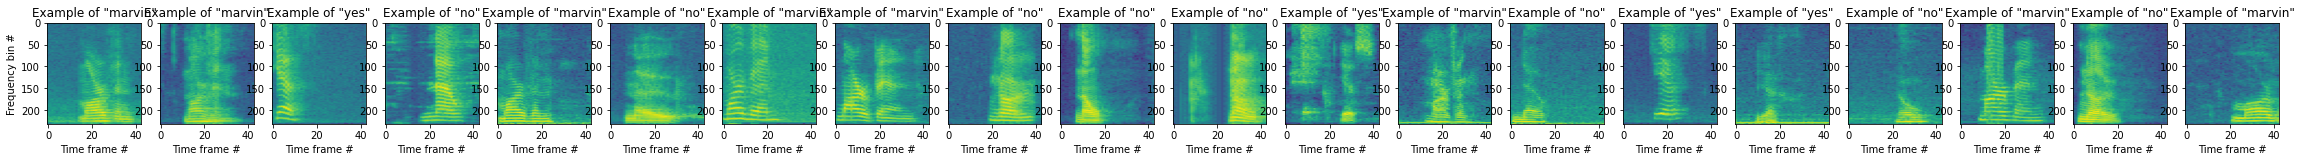

In [128]:
input_wav_paths_and_labels = []
for i, word in enumerate(WORDS):
  wav_paths = glob.glob(os.path.join(DATASET_PATH, word, "*_%shz.wav" % TARGET_SAMPLE_RATE))
  print("Found %d examples for class %s" % (len(wav_paths), word))
  labels = [i] * len(wav_paths)
  input_wav_paths_and_labels.extend(zip(wav_paths, labels))
random.shuffle(input_wav_paths_and_labels)
  
input_wav_paths, labels = ([t[0] for t in input_wav_paths_and_labels],
                           [t[1] for t in input_wav_paths_and_labels])
dataset = get_dataset(input_wav_paths, labels)

# Show some example spectrograms for inspection.
fig = plt.figure(figsize=(40, 100))
dataset_iter = iter(dataset)
num_spectrograms_to_show = 20
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  spectrogram, label = next(dataset_iter)
  spectrogram = spectrogram.numpy()
  label = label.numpy()
  plt.imshow(np.flipud(np.squeeze(spectrogram, -1).T), aspect=0.2)
  ax.set_title("Example of \"%s\"" % WORDS[label])
  ax.set_xlabel("Time frame #")
  if i == 0:
    ax.set_ylabel("Frequency bin #")

In [129]:
# The amount of data we have is relatively small. It fits into typical host RAM
# or GPU memory. For better training performance, we preload the data and
# put it into numpy arrays:
# - xs: The audio features (normalized spectrograms).
# - ys: The labels (class indices).
print(
    "Loading dataset and converting data to numpy arrays. "
    "This may take a few minutes...")
xs_and_ys = list(dataset)
xs = np.stack([item[0] for item in xs_and_ys])
ys = np.stack([item[1] for item in xs_and_ys])
print("Done.")

Loading dataset and converting data to numpy arrays. This may take a few minutes...
Done.


In [131]:
for i in ys:
    print(i)

2
2
1
0
2
0
2
2
0
0
0
1
2
0
1
1
0
2
0
2
2
1
2
2
2
0
1
2
1
0
2
1
2
0
1
1
1
1
1
2
2
3
1
2
2
2
2
1
0
1
0
0
1
1
1
0
2
2
2
0
0
1
0
2
1
0
2
2
2
1
0
2
0
1
0
1
0
1
0
2
2
2
2
0
1
1
2
2
1
0
0
0
2
1
2
1
0
0
1
0
3
0
2
0
2
1
3
1
0
1
2
2
1
2
1
0
2
1
2
0
1
2
2
1
1
2
1
2
0
2
3
2
1
0
2
2
1
0
0
0
3
1
0
2
2
2
0
2
1
2
0
1
2
1
2
2
0
1
0
2
3
0
1
1
1
2
1
1
2
1
0
0
2
2
0
2
1
1
1
1
3
2
2
1
2
2
1
1
3
1
1
2
1
1
1
1
1
2
1
0
2
1
1
1
2
0
2
2
2
0
2
1
1
2
2
1
3
1
1
1
2
1
0
2
1
1
2
1
1
1
0
0
1
2
2
2
1
2
3
2
1
2
0
2
0
1
0
2
3
2
2
2
2
2
1
1
1
0
0
1
0
1
0
1
2
0
2
1
1
2
0
1
1
1
0
2
2
1
1
2
0
1
0
2
1
2
0
2
0
0
1
0
2
1
1
1
1
0
1
2
1
2
1
0
1
2
0
1
2
2
1
1
2
0
1
2
0
0
1
1
1
0
2
1
1
1
1
1
0
1
1
1
0
0
1
0
1
1
0
0
2
2
2
1
1
1
0
0
0
0
1
0
2
2
1
2
1
2
0
0
0
1
1
2
2
0
2
1
0
0
1
0
0
0
0
2
0
2
1
2
2
2
2
1
0
1
1
0
1
2
0
2
0
1
2
2
3
2
2
2
0
2
2
1
1
1
1
0
2
0
2
1
0
3
0
0
2
1
3
2
0
1
1
1
0
0
3
0
2
2
0
0
0
0
2
1
0
1
0
0
0
2
1
0
0
1
2
2
0
1
2
1
0
0
0
1
2
1
0
2
1
1
1
1
1
0
2
2
0
1
1
1
0
1
0
2
3
0
2
1
1
2
1
1
0
1
2
2
1
2
0
3
1
3
2
1
2
1
1
0


In [132]:
tfjs_model_json_path = 'preprocess_model/model.json'

# Load the Speech Commands model. Weights are loaded along with the topology,
# since we train the model from scratch. Instead, we will perform transfer
# learning based on the model.
orig_model = tfjs.converters.load_keras_model(tfjs_model_json_path, load_weights=True)

# Remove the top Dense layer and add a new Dense layer of which the output
# size fits the number of sound classes we care about.
model = tf.keras.Sequential(name="TransferLearnedModel")
for layer in orig_model.layers[:-1]:
  model.add(layer)
model.add(tf.keras.layers.Dense(units=len(WORDS), activation="softmax"))

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "TransferLearnedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 225, 8)        136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 112, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 109, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 51, 32)         8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 25, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 22, 32)

In [134]:
# Train the model.
model.fit(xs, ys, batch_size=256, validation_split=0.3, shuffle=True, epochs=10)

Epoch 1/10
8/8 [==============================] - 4s 466ms/step - loss: 0.2117 - acc: 0.9228 - val_loss: 0.1386 - val_acc: 0.9529
Epoch 2/10
8/8 [==============================] - 3s 434ms/step - loss: 0.1971 - acc: 0.9349 - val_loss: 0.1328 - val_acc: 0.9588
Epoch 3/10
8/8 [==============================] - 3s 431ms/step - loss: 0.1687 - acc: 0.9419 - val_loss: 0.1303 - val_acc: 0.9624
Epoch 4/10
8/8 [==============================] - 3s 425ms/step - loss: 0.1689 - acc: 0.9374 - val_loss: 0.1276 - val_acc: 0.9647
Epoch 5/10
8/8 [==============================] - 3s 393ms/step - loss: 0.1714 - acc: 0.9389 - val_loss: 0.1247 - val_acc: 0.9647
Epoch 6/10
8/8 [==============================] - 3s 405ms/step - loss: 0.1696 - acc: 0.9384 - val_loss: 0.1220 - val_acc: 0.9659
Epoch 7/10
8/8 [==============================] - 3s 423ms/step - loss: 0.1402 - acc: 0.9505 - val_loss: 0.1210 - val_acc: 0.9659
Epoch 8/10
8/8 [==============================] - 3s 404ms/step - loss: 0.1575 - acc: 0.94

In [135]:
# Save the model as TFLite

# Reference *********************************************************************
# We need to combine the preprocessing model and the newly trained 3-class model
# so that the resultant model will be able to preform STFT and spectrogram 
# calculation on mobile devices (i.e., without web browser's WebAudio).

combined_model = tf.keras.Sequential(name='CombinedModel')
combined_model.add(preproc_model)
combined_model.add(model)
combined_model.build([None, WAVEFORM_LEN])
combined_model.summary()

tflite_output_path = './build/panikee_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(combined_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]
with open(tflite_output_path, 'wb') as f:
    f.write(converter.convert())
print("Saved tflite file at: %s" % tflite_output_path)

Model: "CombinedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_preproc (Sequential)   (None, None, 232, 1)      2048      
_________________________________________________________________
TransferLearnedModel (Sequen (None, 4)                 1436668   
Total params: 1,438,716
Trainable params: 8,004
Non-trainable params: 1,430,712
_________________________________________________________________


INFO:tensorflow:Assets written to: /tmp/tmpbxcqrg4n/assets


INFO:tensorflow:Assets written to: /tmp/tmpbxcqrg4n/assets


Saved tflite file at: ./build/panikee_model.tflite
